In [1]:
import glob
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import random
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
import datetime
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D,
                          Conv1D, MaxPool1D, Conv2D, Dropout, Conv3D, Concatenate)

In [2]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, 
                data_directory_path: str = "./",
                labels_directory_path: str = "./",
                is_directory_recursive: bool = False,
                file_type: str = "*csv",
                data_format: str = "2D",
                batch_size: int = 32,
                file_count = None,
                labels_list: Union[List,str] = "cotAlpha",
                to_standardize: bool = False,
                input_shape: Tuple = (13,21),
                include_y_local:bool = False,
                **kwargs,
                ):
        """
        Data Generator to streamline data input to the network direct from the directory.
        Args:
        data_directory_path:
        labels_directory_path: 
        is_directory_recursive: 
        file_type: Default: "*.csv"
                   Adapt the data loader according to file type. For now, it only supports .csv file format.
        data_format: Default: 2D
                     Used to refer to the relevant "recon" files, 2D for 2D pixel array, 3D for time series input,
        batch_size: Default: 32
                    The no. of data points to be included in a single batch.
        file_count: Default: None
                    To limit the no. of .csv files to be used for training.
                    If set to None, all files will be considered as legitimate inputs.
        labels_list: Default: "cotAlpha"
                     Input column name or list of column names to be used as label input to the neural network.
        to_standardize: If set to True, it ensures that batches are normalized prior to being used as inputs
                        for training.
                        Default: False
        input_shape: Default: (13,21) for image input to a 2D feedforward neural network.
                    To reshape the input array per the requirements of the network training.
        """
        self.recon_files = glob.glob(data_directory_path + "recon" + data_format + file_type, 
                                    recursive=is_directory_recursive)
        
        self.recon_files.sort()
        print(len(self.recon_files))
        self.label_files = glob.glob(labels_directory_path + "labels" + file_type, 
                                     recursive=is_directory_recursive)
        self.label_files.sort()
        
        if file_count != None:
            self.recon_files = self.recon_files[:file_count]
            self.label_files = self.label_files[:file_count]
            
        self.batch_size = batch_size
        self.labels_list = labels_list
        self.input_shape = input_shape
        self.to_standardize = to_standardize
        self.include_y_local = include_y_local
        self.on_epoch_end()
        
    
    def standardize(self, x):
        """Applies the normalization configuration in-place to a batch of
        inputs.
        `x` is changed in-place since the function is mainly used internally
        to standardize images and feed them to your network.
        Args:
            x: Batch of inputs to be normalized.
        Returns:
            The inputs, normalized. 
        """
        x -= np.mean(x, keepdims=True)   
        x /= np.std(x, keepdims=True) + 1e-10
        return x
        
            
    def on_epoch_end(self):
        """
        Inherited from the parent class.
        Used to reset indices but not of significance in this datagenerator.
        """
        pass
            
        
    def __getitem__(self, index):
        """
        Used to fetch a batch of inputs (X,y) for the network's training.
        """
        
        file_index = random.randrange(0,len(self.recon_files))
        recon_df = pd.read_csv(self.recon_files[file_index])
        labels_df = pd.read_csv(self.label_files[file_index])
        
        chosen_idxs = random.sample([i for i in range(0,len(labels_df))], self.batch_size)
        
        X = recon_df.iloc[chosen_idxs].values
        if len(self.input_shape) == 1:
            X = X.reshape(self.batch_size,self.input_shape[0])
        if len(self.input_shape) == 2:
            X = X.reshape(self.batch_size,self.input_shape[0],self.input_shape[1])
        elif len(self.input_shape) == 3:
            X = X.reshape(self.batch_size,self.input_shape[0],self.input_shape[1],
                          self.input_shape[2])
        elif len(self.input_shape) == 4:
            X = X.reshape(self.batch_size, self.input_shape[0], self.input_shape[1], 
                          self.input_shape[2], self.input_shape[3])
            
        y = labels_df.iloc[chosen_idxs][self.labels_list].values
        if self.to_standardize:
            X = self.standardize(X)
        if self.include_y_local:
            y_local = labels_df.iloc[chosen_idxs]["y-local"].values
            return [X, y_local], y
        else:
            return X, y
    
    def __len__(self):
        count = 0
        for f in self.label_files:
            x = pd.read_csv(f)
            count += x.shape[0]
        return count // self.batch_size

In [8]:
def custom_loss(y, p):

    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359

    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.gather(params=p, indices=[1], axis=1)

    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(tf.math.multiply_no_nan(likelihood,tf.cast(sigma>0,tf.float32)),minval,maxval)

    NLL = tf.clip_by_value(-1*tf.math.log(likelihood),minval,maxval)

    return tf.keras.backend.sum(NLL,axis=1)

def custom_loss_double_gaussian(y, p):
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma1 = tf.gather(params=p, indices=[1], axis=1)
    sigma2 = tf.gather(params=p, indices=[2], axis=1)
    A = tf.gather(params=p, indices=[3], axis=1)
    norm1 = tf.math.sqrt(2*pi)*sigma1
    norm2 = tf.math.sqrt(2*pi)*sigma2
    normtot = norm1 + A*norm2
    term1 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma1*sigma1))
    term2 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma2*sigma2))
    likelihood = (term1 + A*term2)/normtot
    likelihood = tf.math.multiply_no_nan(likelihood,tf.cast(sigma1>0,tf.float32)*tf.cast(sigma2>0,tf.float32))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)


In [6]:
class RegModelCotAlpha2D:

    def build_image_branch(self,inputs):
        x = Flatten()(inputs)
        x = Dense(32, kernel_initializer = "glorot_normal", activation='sigmoid', use_bias = True)(x)
        x = Dense(16, kernel_initializer = "glorot_normal", activation='sigmoid', use_bias = True)(x)
        x = Dense(4, activation= "linear", name = "final_output")(x)

        return x
 
    def assemble_model(self):
        inputs = Input ( shape = (10,21,1) )
        outputs = self.build_image_branch(inputs)
        model = Model(inputs =inputs, outputs=outputs, name = "cotAlpha_2D_x_profile_model")
        print( model.summary() )
        return model

In [9]:
start_date = datetime.datetime.now ( )
epochs = 100
batch_size = 5000
val_batch_size = 5000
use_file_size = None
training_generator = CustomDataGenerator(
                                        data_directory_path = "./data/processed/3Dto2DX/",
                                        labels_directory_path = "./data/raw/labels/",
                                        is_directory_recursive = False,
                                        file_type = "*csv",
                                        data_format = "3D",
                                        batch_size = batch_size,
                                        file_count = use_file_size,
                                        to_standardize= True,
                                        include_y_local= False,
                                        labels_list = "cotAlpha",
                                        input_shape = (10,21,1))

validation_generator = CustomDataGenerator(
                                        data_directory_path = "./data/processed/3Dto2DX/",
                                        labels_directory_path = "./data/raw/labels/",
                                        is_directory_recursive = False,
                                        file_type = "*csv",
                                        data_format = "3D",
                                        batch_size = val_batch_size,
                                        file_count = 25,
                                        to_standardize= True,
                                        include_y_local= False,
                                        labels_list = "cotAlpha",
                                        input_shape = (10,21,1))

es = keras.callbacks.EarlyStopping(
                                   patience = 5, 
                                   min_delta= 1e-5,
                                   mode="min")

model = RegModelCotAlpha2D().assemble_model()

model.compile(optimizer = tf.keras.optimizers.Adam(lr =5e-3), 
              loss = custom_loss_double_gaussian,
              metrics = ["mse"])

history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks = [es],
                    verbose = True)

end_date = datetime.datetime.now ( )
print ( "Total Training Time = {}".format (end_date - start_date ) )

70
70
Model: "cotAlpha_2D_x_profile_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 21, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 210)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                6752      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 final_output (Dense)        (None, 4)                 68        
                                                                 
Total params: 7,348
Trainable params: 7,348
Non-trainable params: 0
_________________________________________________________________
None


/Users/gpradhan/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


2022-11-03 13:05:21.494631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - ETA: 0s - loss: 2.5711 - mse: 10.4298

2022-11-03 13:06:19.208275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - 66s 239ms/step - loss: 2.5711 - mse: 10.4298 - val_loss: 10.6321 - val_mse: 11.3386
Epoch 2/100
270/270 [==============================] - 64s 233ms/step - loss: 3.2207 - mse: 14.0499 - val_loss: 7.9243 - val_mse: 12.7533
Epoch 3/100
270/270 [==============================] - 64s 233ms/step - loss: 4.0780 - mse: 12.2957 - val_loss: 2.2826 - val_mse: 12.0387
Epoch 4/100
270/270 [==============================] - 66s 241ms/step - loss: 2.8926 - mse: 11.5755 - val_loss: 3.2380 - val_mse: 11.4699
Epoch 5/100
270/270 [==============================] - 65s 236ms/step - loss: 5.4050 - mse: 11.2604 - val_loss: 3.8291 - val_mse: 11.3747
Epoch 6/100
270/270 [==============================] - 64s 232ms/step - loss: 2.9303 - mse: 10.6965 - val_loss: 2.2244 - val_mse: 10.8529
Epoch 7/100
270/270 [==============================] - 65s 237ms/step - loss: 2.0494 - mse: 10.9139 - val_loss: 1.9856 - val_mse: 11.2861
Epoch 8/100
270/270 [========================

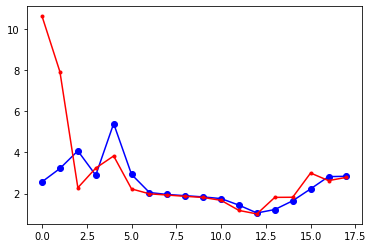

In [10]:
plt.plot(history.history["loss"], color = "blue",marker = "o")
plt.plot(history.history["val_loss"], color ="red", marker = ".")
# plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.show()

### Test Phase:

In [11]:
test_recon = pd.read_csv("./data/test/recon3Dto2D_10TS_test.csv")
test_labels_df = pd.read_csv("./data/test/labels_test.csv")
test_labels = test_labels_df["cotAlpha"]
test_y_local = test_labels_df["y-local"]
print(test_recon.shape, test_labels.shape)

(99710, 210) (99710,)


In [12]:
test_inputs = test_recon.values.reshape(test_recon.shape[0],10,21,1)

def standardize(x):
    """Applies the normalization configuration in-place to a batch of
    inputs.
    `x` is changed in-place since the function is mainly used internally
    to standardize images and feed them to your network.
    Args:
        x: Batch of inputs to be normalized.
    Returns:
        The inputs, normalized. 
    """
    x -= np.mean(x, keepdims=True)   
    x /= np.std(x, keepdims=True) + 1e-10
    return x

test_inputs = standardize(test_inputs)
# cotBeta_predictions = model.predict(test_inputs, batch_size = 1000)
cotAlpha_predictions = model.predict(test_inputs, batch_size = 1000)
# cotBeta_predictions = model.predict([test_inputs,test_y_local.values], batch_size = 1000)
df = pd.DataFrame(cotAlpha_predictions, columns = ["mu","sigma_1","sigma_2", "relative_norm"])
df["truth"] = test_labels

2022-11-03 13:30:17.290973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


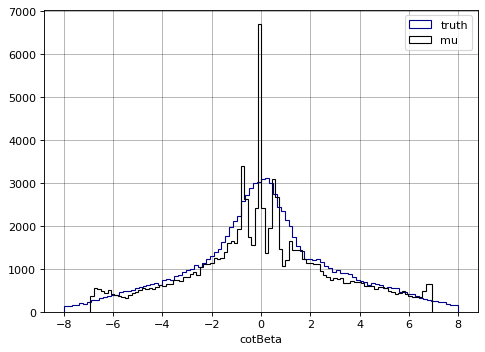

In [13]:
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(df["truth"], bins = 100, color = "darkblue", histtype = "step" )
plt.hist(df["mu"], bins = 100, color = "black", histtype = "step" )
plt.xlabel("cotBeta")
plt.legend(["truth", "mu"])
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [14]:
# df.to_csv("./results.csv", index = False)

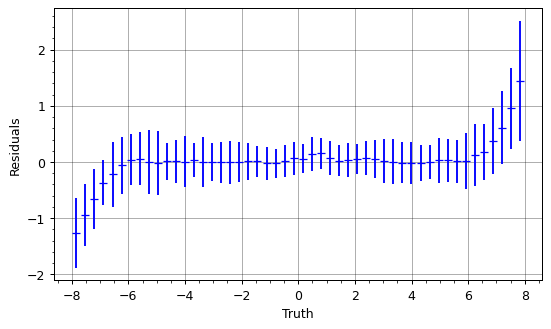

In [15]:
def compute_profile(x, y, nbin=100):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

plt.figure(figsize = (7,4), dpi= 90)
p_x, p_mean, p_rms = compute_profile(x = df["truth"],
                                     y = df["truth"] - df["mu"],
                                     nbin = 50)
plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='blue', color='blue')

plt.xlabel("Truth")
plt.ylabel("Residuals")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

0.03648056995261256 0.386782586491672


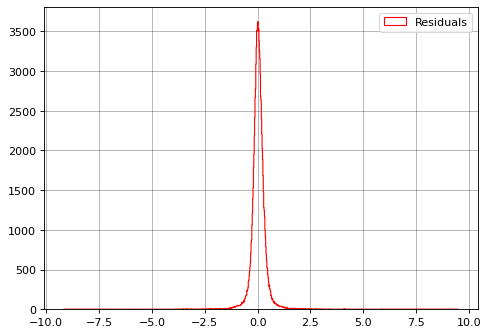

In [16]:
residuals = df["truth"] - df["mu"]
print(np.mean(residuals), np.std(residuals))
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(residuals, bins = 1000, color = "red", histtype = "step")
plt.legend(["Residuals"])
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

-1.0567469501806326 184.82000122633488


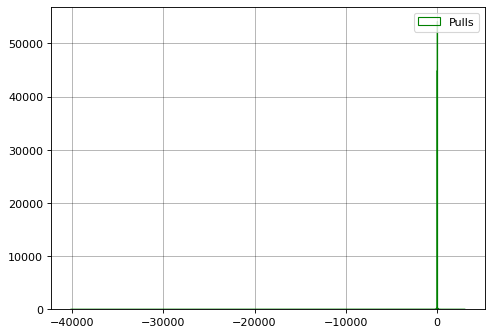

In [17]:
pulls = (df["mu"] - df["truth"])/ df["sigma_1"]
print(np.mean(pulls), np.std(pulls))
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(pulls, bins = 1000, color = "green", histtype = "step")
plt.legend(["Pulls"])
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()